In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [80]:
df = pd.read_csv("raw_with_bbox.csv", index_col = 0)
print(df.head())

          spikelets_num  H1S1V1  H1S2V1  H1S3V1   H2S1V1  H2S2V1  H2S3V1  \
name                                                                       
IMG_0500             20   48174  195417   25910  2750198  176212   13045   
IMG_0924             20  108533   88542  102115  1192944  347924   16092   
IMG_9890             33  393710  296880  180414   924097  382477  134211   
IMG_0020             29  573241  270465  133195   656285  116332   82226   
IMG_0312             20  113010  410681  200295  1873092  973057   42374   

          H3S1V1  H3S2V1  H3S3V1  ...  H2S1V3  H2S2V3   H2S3V3  H3S1V3  \
name                              ...                                    
IMG_0500   11715    6811    3746  ...  295226   58114     2073     267   
IMG_0924  244392   84543    4221  ...   18415    1372    99526    3355   
IMG_9890  173888   69485    8739  ...  106973  133324  4608062    6649   
IMG_0020  147906   20231    3021  ...   95905   83092  1124684    2929   
IMG_0312  320172   4289

In [81]:
scaler = StandardScaler()
df_std = scaler.fit_transform(df)

pca = PCA()
pca.fit(df_std)
variance_ratio = pca.explained_variance_ratio_
print(pca.explained_variance_)

[7.33987924e+00 5.47564992e+00 4.16852487e+00 3.41314880e+00
 2.62792220e+00 2.39022672e+00 1.36745963e+00 9.60052834e-01
 8.97086301e-01 4.71438835e-01 3.72718583e-01 3.67424040e-01
 3.02668790e-01 2.86363063e-01 2.11192492e-01 1.89642675e-01
 1.80823823e-01 1.59105650e-01 1.40269972e-01 1.19133839e-01
 1.09462218e-01 9.25651382e-02 7.90935977e-02 6.47651959e-02
 5.73022011e-02 4.82756133e-02 3.98624165e-02 3.75642145e-02
 2.07688047e-02 1.55570918e-02 9.29892997e-03 6.91296838e-03]


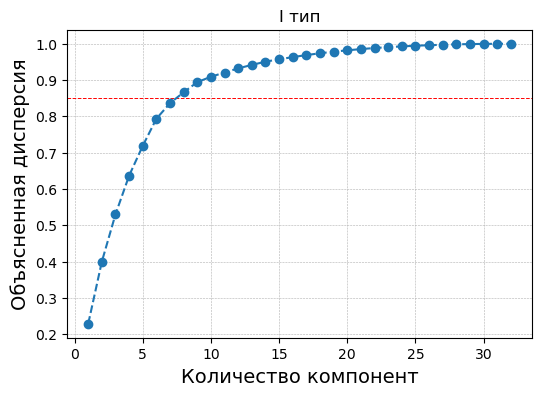

In [82]:
fig = plt.figure(figsize = (6, 4))
plt.grid(linestyle='--', lw=0.4)
plt.axhline(y=0.85, color='red', linestyle='--', lw=0.7)
variance_plot_points = plt.plot(range(1, len(variance_ratio) + 1),
                                variance_ratio.cumsum(),
                                marker = "o",
                                linestyle = "--")
plt.xlabel("Количество компонент", size=14)
plt.ylabel("Объясненная дисперсия", size=14)
plt.title("I тип")
plt.show()
fig.savefig('I_type.jpg', dpi=300)

In [83]:
chosen_components = len([i for i in variance_plot_points[0].get_data()[1] if i <= 0.85])
print(chosen_components)

7


In [84]:
pca = PCA(n_components = chosen_components)
pca.fit(df_std)
pca.transform(df_std)

pca_scores = pca.transform(df_std)

In [85]:
cluster_num_for_testing = 20
wcss = []
for i in range(1, cluster_num_for_testing + 1):
    kmeans_pca = KMeans(n_clusters = i, init = "k-means++", random_state = 42)
    kmeans_pca.fit(pca_scores)
    wcss.append(kmeans_pca.inertia_)

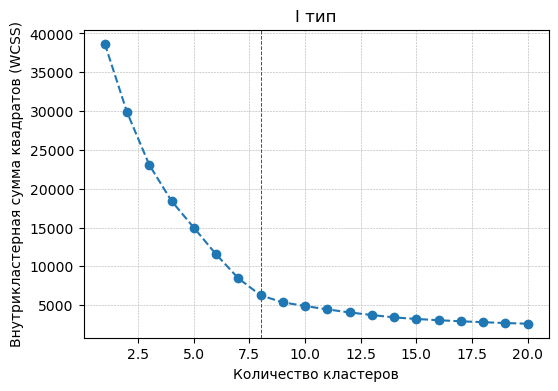

In [86]:
fig = plt.figure(figsize = (6, 4))
plt.axvline(x=8, color='red', linestyle='--', lw=0.7)
plt.grid(linestyle='--', lw=0.4)
cluster_plot_points = plt.plot(range(1, cluster_num_for_testing + 1),
                               wcss,
                               marker = "o",
                               linestyle = "--")
plt.xlabel("Количество кластеров")
plt.ylabel("Внутрикластерная сумма квадратов (WCSS)")
plt.title("I тип")
plt.show()
fig.savefig('I_cluster.jpg', dpi=300)

In [87]:
x = cluster_plot_points[0].get_data()[0]
y = cluster_plot_points[0].get_data()[1]
x
y

array([38674.37963058, 29843.58355957, 23067.83670965, 18419.20760895,
       14987.26039313, 11555.37836763,  8469.55117434,  6269.68618434,
        5362.09087398,  4890.28874937,  4455.32572189,  4063.52934952,
        3734.66631571,  3424.70314299,  3223.08976848,  3059.50339138,
        2925.58225546,  2806.17962576,  2696.55159116,  2608.70174048])

In [88]:
tangents = []

for i in range(len(x) - 1):
    tangents.append(abs(y[i] - y[i+1]) / abs(x[i] - x[i+1]))
difference = [abs(tangents[i] - tangents[i+1]) for i in range(len(tangents) - 1)]

In [89]:
chosen_clusters = 0
for i in difference:
    if i < 336 and i > 6:
        break
    chosen_clusters += 1
print(chosen_clusters)

8


In [90]:
kmeans_pca = KMeans(n_clusters = chosen_clusters, init = "k-means++", random_state = 42)
kmeans_pca.fit(pca_scores)

KMeans(random_state=42)

In [91]:
df_pca_kmeans = pd.concat([df.reset_index(drop = True),
                          pd.DataFrame(pca_scores)],
                          axis = 1)
component_names = [f"{i} компонента" for i in range(1, chosen_components + 1)]
df_pca_kmeans.columns.values[-chosen_components:] = component_names
df_pca_kmeans["Cluster"] = kmeans_pca.labels_
print(df_pca_kmeans.head())

   spikelets_num  H1S1V1  H1S2V1  H1S3V1   H2S1V1  H2S2V1  H2S3V1  H3S1V1  \
0             20   48174  195417   25910  2750198  176212   13045   11715   
1             20  108533   88542  102115  1192944  347924   16092  244392   
2             33  393710  296880  180414   924097  382477  134211  173888   
3             29  573241  270465  133195   656285  116332   82226  147906   
4             20  113010  410681  200295  1873092  973057   42374  320172   

   H3S2V1  H3S3V1  ...  bbox_height  spike_perimeter  1 компонента  \
0    6811    3746  ...    98.028236       235.237303      4.740895   
1   84543    4221  ...   109.315790       242.632225      1.133428   
2   69485    8739  ...   178.247353       504.643601     -2.916202   
3   20231    3021  ...   169.805151       756.397338     -2.126787   
4   42897   10667  ...   102.569745       245.727222      4.655104   

   2 компонента  3 компонента  4 компонента  5 компонента  6 компонента  \
0     -2.469009     -1.009427      2.0407

In [92]:
possible_names = ["1", "2", "3", "4", "5", "6", "7", "8"]
map_cluster_on_names = {}
for i in range(chosen_clusters):
    map_cluster_on_names[i] = possible_names[i]
df_pca_kmeans["Cluster Name"] = df_pca_kmeans["Cluster"].map(map_cluster_on_names)
print(df_pca_kmeans)

      spikelets_num  H1S1V1  H1S2V1  H1S3V1   H2S1V1  H2S2V1  H2S3V1  H3S1V1  \
0                20   48174  195417   25910  2750198  176212   13045   11715   
1                20  108533   88542  102115  1192944  347924   16092  244392   
2                33  393710  296880  180414   924097  382477  134211  173888   
3                29  573241  270465  133195   656285  116332   82226  147906   
4                20  113010  410681  200295  1873092  973057   42374  320172   
...             ...     ...     ...     ...      ...     ...     ...     ...   
1440             11  110175   62615   22295  1278092   80297   22189   29648   
1441             21   61330  159618   75859  2663722  182442   10688   62213   
1442             26  456875  292471  179651  1249784  160182   95248  280003   
1443             27   83813   88862  118778  1084644  633930   16563  132314   
1444             21  251631   16686   33182   152301  352303  160665    8949   

      H3S2V1  H3S3V1  ...  spike_perime

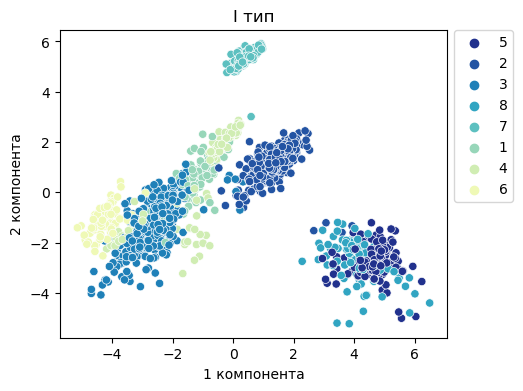

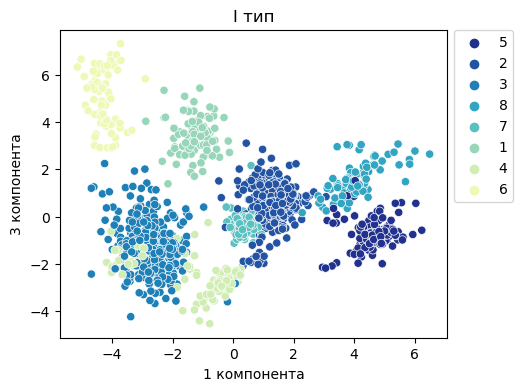

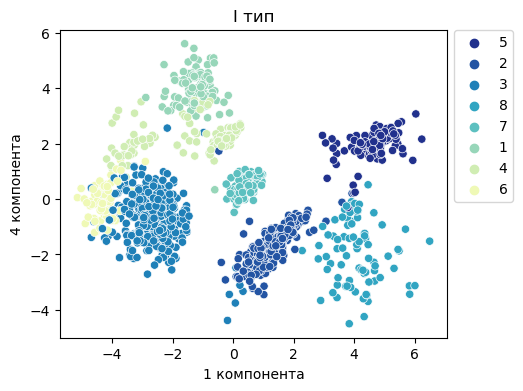

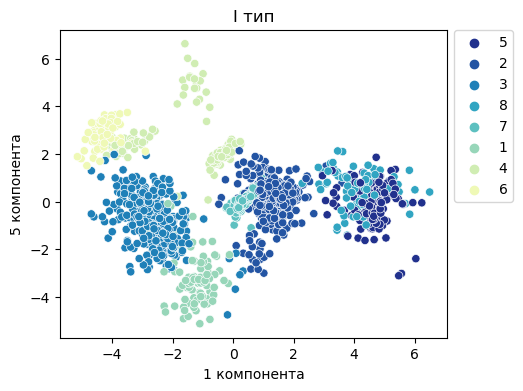

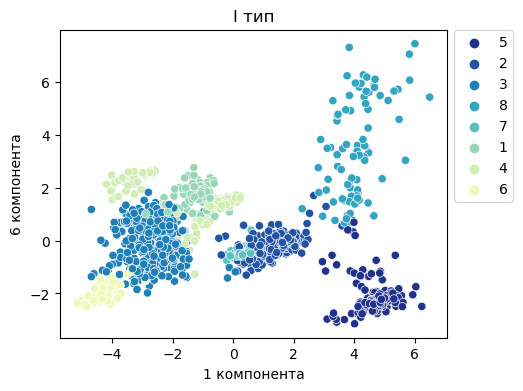

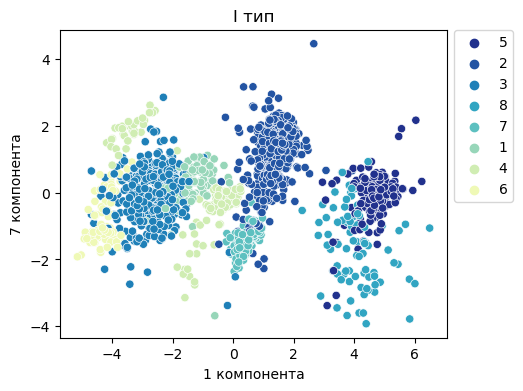

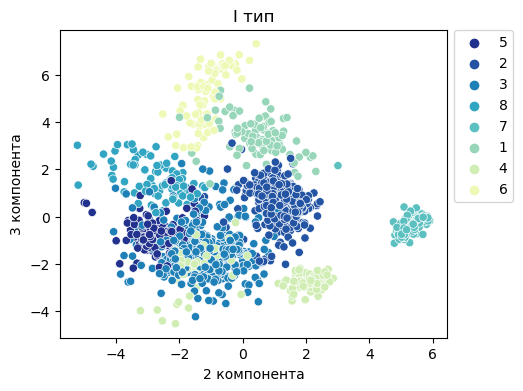

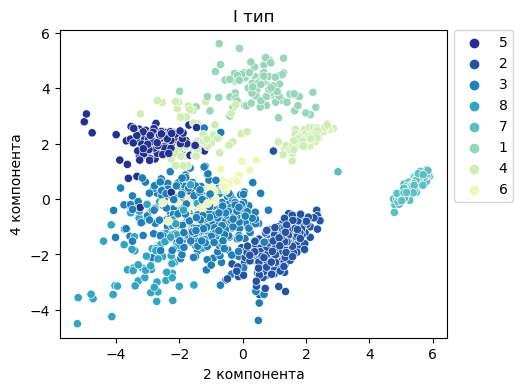

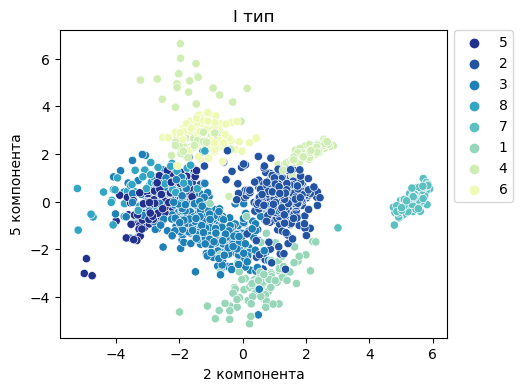

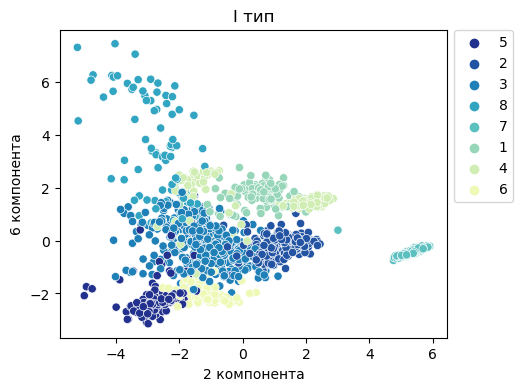

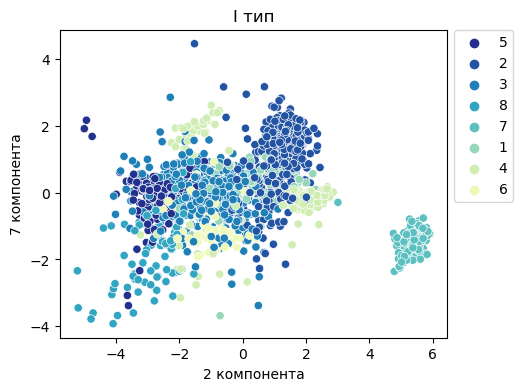

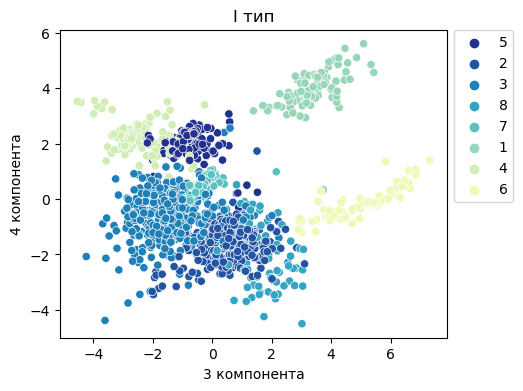

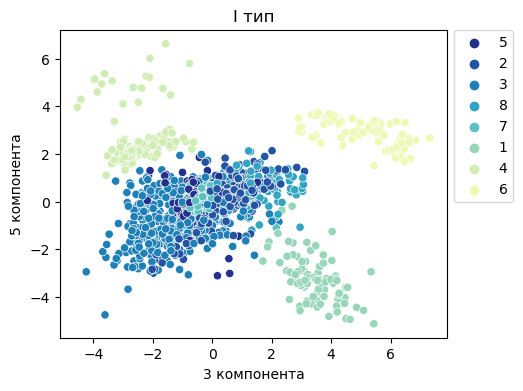

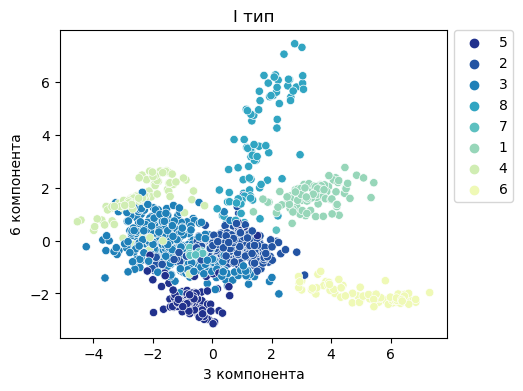

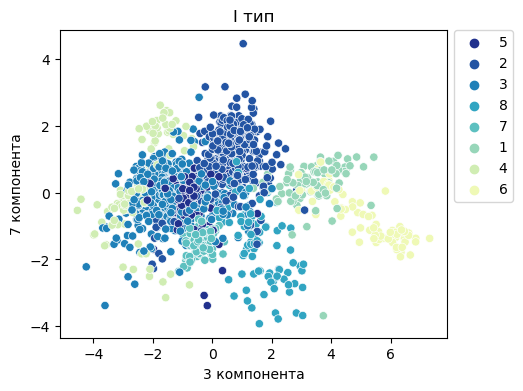

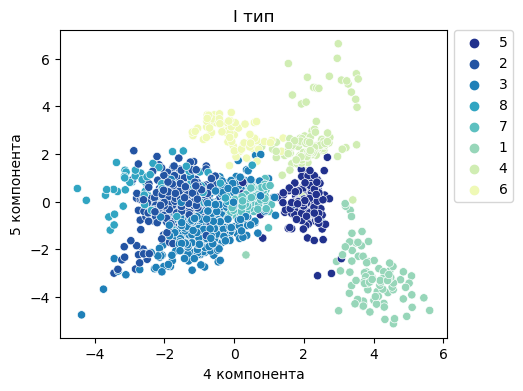

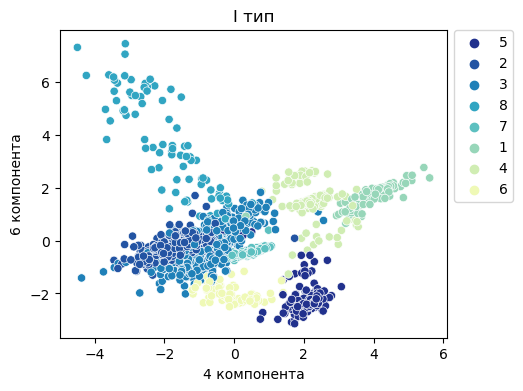

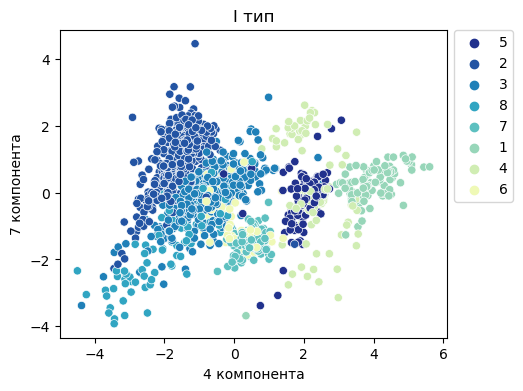

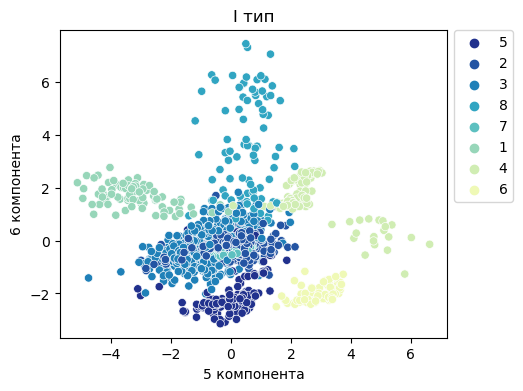

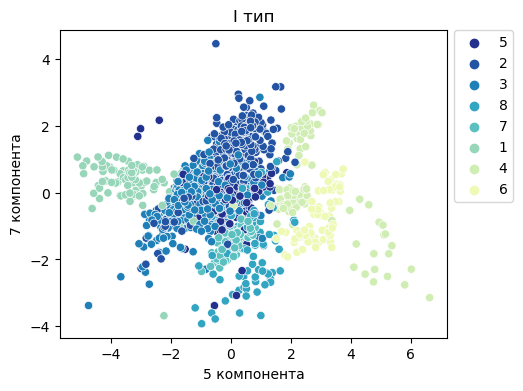

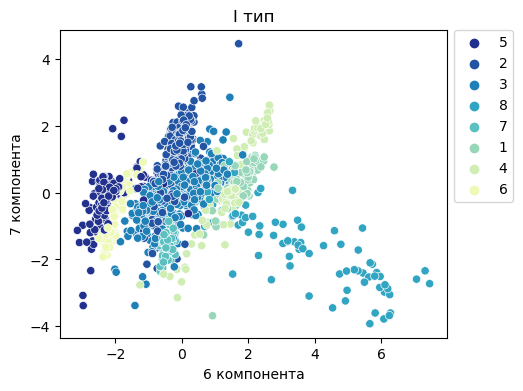

In [16]:
for first in component_names:
    component_names_slice = component_names[component_names.index(first) + 1:]
    for second in component_names_slice:
        fig = plt.figure(figsize = (5, 4))
        sns.scatterplot(x=df_pca_kmeans[first], 
                        y=df_pca_kmeans[second], 
                        hue = df_pca_kmeans["Cluster Name"], 
                        palette = reversed(sns.color_palette("YlGnBu", n_colors=chosen_clusters)))
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.72))
        plt.title("I тип")
        plt.show()
        fig.savefig(f"raw_plots/{first}_{second}.png", bbox_inches='tight', dpi=300)

In [74]:
new_df = df
new_df.reset_index(inplace=True)
print(new_df)

          name  spikelets_num  H1S1V1  H1S2V1  H1S3V1   H2S1V1  H2S2V1  \
0     IMG_0500             20   48174  195417   25910  2750198  176212   
1     IMG_0924             20  108533   88542  102115  1192944  347924   
2     IMG_9890             33  393710  296880  180414   924097  382477   
3     IMG_0020             29  573241  270465  133195   656285  116332   
4     IMG_0312             20  113010  410681  200295  1873092  973057   
...        ...            ...     ...     ...     ...      ...     ...   
1440    7251_4             11  110175   62615   22295  1278092   80297   
1441  IMG_0516             21   61330  159618   75859  2663722  182442   
1442  IMG_9580             26  456875  292471  179651  1249784  160182   
1443  IMG_1159             27   83813   88862  118778  1084644  633930   
1444    8755_4             21  251631   16686   33182   152301  352303   

      H2S3V1  H3S1V1  H3S2V1  ...  H2S1V3  H2S2V3    H2S3V3  H3S1V3  H3S2V3  \
0      13045   11715    6811  ..

In [75]:
df_result = pd.concat([new_df["name"],df_pca_kmeans["Cluster"]], join = 'outer', axis = 1)
print(df_result)

df_result.to_csv("raw_clusters_with_bbox.csv", index=False)

          name  Cluster
0     IMG_0500        4
1     IMG_0924        1
2     IMG_9890        2
3     IMG_0020        2
4     IMG_0312        7
...        ...      ...
1440    7251_4        3
1441  IMG_0516        4
1442  IMG_9580        2
1443  IMG_1159        1
1444    8755_4        6

[1445 rows x 2 columns]
